In [1]:
# Import data manipulation and analysis libraries
import pandas as pd  # for working with tabular data
import numpy as np   # for numerical operations
import matplotlib.pyplot as plt  # for plotting
import seaborn as sns  # for advanced visualizations
import unicodedata  # for removing accents and normalizing text

# Load standard performance statistics for Serie A players
df_std = pd.read_csv('seriea_2024_2025_stats/seriea_standard_stats.csv')

# Load shooting-specific statistics for Serie A players
df_shoot = pd.read_csv('seriea_2024_2025_stats/seriea_shooting_stats.csv')


In [2]:
# Merge key shooting statistics into the main standard stats dataframe
df_merged = pd.merge(
    df_std,
    df_shoot[['Player', 'Squad', 'Standard_Sh', 'Standard_SoT', 'Standard_Gls', 'Standard_PK', 'Standard_PKatt']],
    on=['Player', 'Squad'],  # Merge on both player and team name
    how='inner'  # Keep only players present in both datasets
)

# Define a function to remove accents from text (e.g., "é" -> "e")
def remove_accents(text):
    if pd.isnull(text):
        return ""
    return ''.join(
        c for c in unicodedata.normalize('NFKD', str(text))
        if not unicodedata.combining(c)
    )

# Clean and standardize player and squad names for consistency
df_merged['Player'] = df_merged['Player'].apply(remove_accents).str.lower().str.strip()
df_merged['Squad'] = df_merged['Squad'].apply(remove_accents).str.lower().str.strip()

# Convert relevant columns to numeric types for calculation
df_merged['Min'] = pd.to_numeric(df_merged['Playing Time_Min'], errors='coerce')  # Minutes played
df_merged['Goals'] = pd.to_numeric(df_merged['Performance_Gls'], errors='coerce')  # Goals scored
df_merged['Shots'] = pd.to_numeric(df_merged['Standard_Sh'], errors='coerce')  # Total shots
df_merged['SoT'] = pd.to_numeric(df_merged['Standard_SoT'], errors='coerce')  # Shots on target

# Calculate per-player shooting metrics
df_merged['Goals_per90'] = df_merged['Goals'] / (df_merged['Min'] / 90)  # Goals per 90 minutes
df_merged['Shot_Conversion'] = df_merged['Goals'] / df_merged['Shots']  # % of shots that became goals
df_merged['SoT_pct'] = df_merged['SoT'] / df_merged['Shots']  # % of shots that were on target


In [3]:
# Create a working copy of the merged dataset focused on attacking players
attackers = df_merged.copy()

# Filter out players with low sample sizes to ensure meaningful analysis
# - At least 20 total shots
# - At least 5 goals
# - At least 10 matches played
attackers = attackers[
    (attackers['Shots'] >= 20) &
    (attackers['Goals'] >= 5) &
    (attackers['Playing Time_MP'] >= 10)
]


In [9]:
# Calculate conversion rate and xG per shot
attackers['Shot_Conversion'] = attackers['Goals'] / attackers['Shots']
attackers['xG_per_shot'] = attackers['Expected_xG'] / attackers['Shots']
xg_mean = attackers['xG_per_shot'].mean()
conv_mean = attackers['Shot_Conversion'].mean()


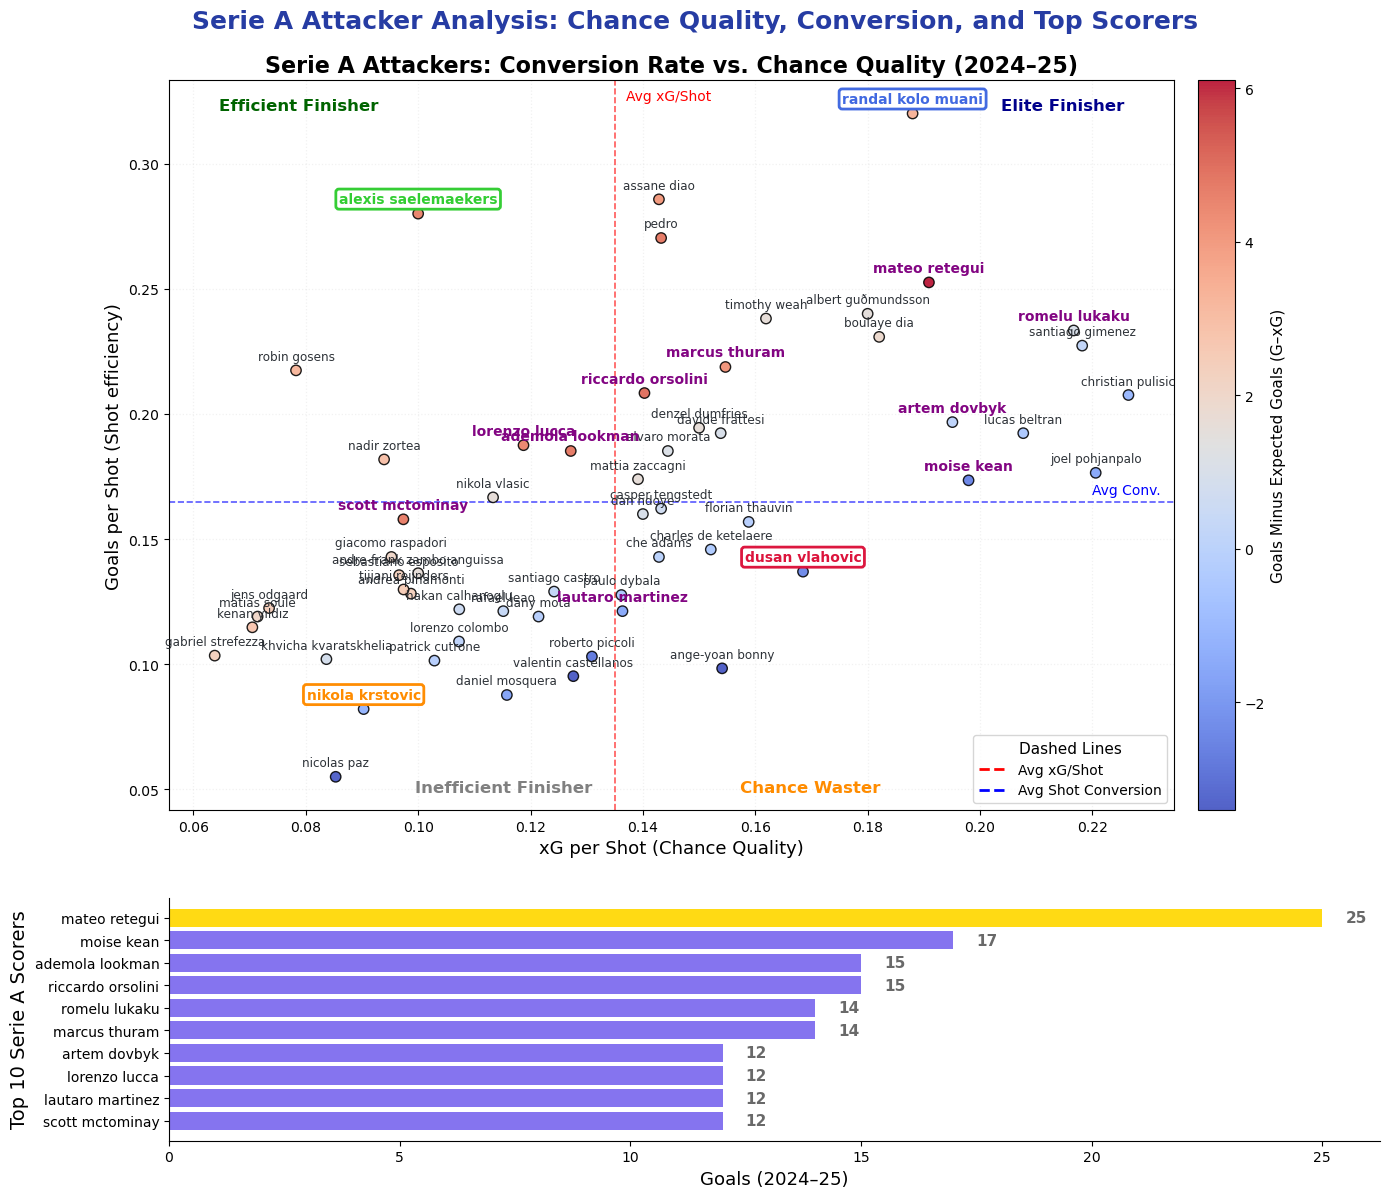

In [16]:
# Import plotting libraries for visualizations
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D  # For custom legend entries

# Set global font for consistency across plots
plt.rcParams['font.family'] = 'DejaVu Sans'

# Set up the figure: two vertically stacked subplots (scatter on top, bar below)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12), gridspec_kw={'height_ratios': [3, 1]})

dot_size = 56  # Size of each scatterplot marker

# Compute means for reference lines in the scatter plot
xbar = attackers['xG_per_shot'].mean()
ybar = attackers['Shot_Conversion'].mean()

# --- TOP 10 SCORERS ---
top_n = 10
top_scorers = attackers.nlargest(top_n, 'Goals').sort_values('Goals', ascending=False)
top_scorer_indices = set(top_scorers.index)  # Used to highlight top scorers

# --- Compute G–xG for color encoding ---
attackers['G_minus_xG'] = attackers['Goals'] - attackers['Expected_xG']

# --- SCATTERPLOT (ax1) ---
sc = ax1.scatter(
    attackers['xG_per_shot'],              # x-axis: chance quality
    attackers['Shot_Conversion'],          # y-axis: shot efficiency
    s=dot_size,                            # dot size
    c=attackers['G_minus_xG'],             # color-coded by G–xG
    cmap='coolwarm',
    alpha=0.88,
    edgecolor='k',
    zorder=3
)

# Add colorbar to show G–xG scale
cbar = plt.colorbar(sc, ax=ax1, orientation='vertical', pad=0.02)
cbar.set_label('Goals Minus Expected Goals (G–xG)', fontsize=11)

# Add average reference lines
ax1.axvline(xbar, color='red', linestyle='--', linewidth=1.2, alpha=0.65, zorder=2)
ax1.axhline(ybar, color='blue', linestyle='--', linewidth=1.2, alpha=0.65, zorder=2)

# Annotate the average lines
ax1.text(xbar+0.002, ax1.get_ylim()[1]*0.99, "Avg xG/Shot", color='red', fontsize=10, ha='left', va='top')
ax1.text(ax1.get_xlim()[1]*0.99, ybar+0.002, "Avg Conv.", color='blue', fontsize=10, ha='right', va='bottom')

# Label axes and add title
ax1.set_xlabel('xG per Shot (Chance Quality)', fontsize=13)
ax1.set_ylabel('Goals per Shot (Shot efficiency)', fontsize=13)
ax1.set_title('Serie A Attackers: Conversion Rate vs. Chance Quality (2024–25)', fontsize=16, fontweight='bold')
ax1.grid(alpha=0.17, linestyle=':', zorder=0, linewidth=0.9)

# Legend for dashed reference lines
legend_elements = [
    Line2D([0], [0], color='red', lw=2, linestyle='--', label='Avg xG/Shot'),
    Line2D([0], [0], color='blue', lw=2, linestyle='--', label='Avg Shot Conversion')
]
ax1.legend(handles=legend_elements, loc='lower right', fontsize=10, frameon=True, title="Dashed Lines", title_fontsize=11)

# --- Annotate Quadrant Labels ---
x_min, x_max = ax1.get_xlim()
y_min, y_max = ax1.get_ylim()
dx = (x_max - x_min) * 0.05
dy = (y_max - y_min) * 0.04

ax1.text(x_min + dx, y_max - dy, 'Efficient Finisher', fontsize=12, color='darkgreen', weight='bold')
ax1.text(x_max - dx, y_max - dy, 'Elite Finisher', fontsize=12, color='darkblue', weight='bold', ha='right')
ax1.text(x_min + (xbar - x_min) * 0.75, y_min + (ybar - y_min) * 0.05,
         'Inefficient Finisher', fontsize=12, color='gray', weight='bold', ha='center', va='bottom')
ax1.text(xbar + (x_max - xbar) * 0.35, y_min + (ybar - y_min) * 0.05,
         'Chance Waster', fontsize=12, color='darkorange', weight='bold', ha='center', va='bottom')

# --- Highlight Outlier Players in Each Quadrant ---
highlight_indices = []
quad_colors = ['limegreen', 'royalblue', 'crimson', 'darkorange']

# Top-left: High conversion, low xG/shot
tl = attackers[(attackers['xG_per_shot'] < xbar) & (attackers['Shot_Conversion'] > ybar)]
if not tl.empty:
    highlight_indices.append(tl['Shot_Conversion'].idxmax())

# Top-right: High conversion, high xG/shot
tr = attackers[(attackers['xG_per_shot'] > xbar) & (attackers['Shot_Conversion'] > ybar)]
if not tr.empty:
    highlight_indices.append(tr['Shot_Conversion'].idxmax())

# Bottom-right: Highlight specific player (Vlahovic)
br = attackers[attackers['Player'].str.lower() == 'dusan vlahovic']
if not br.empty:
    highlight_indices.append(br.index[0])

# Bottom-left: Highlight specific player (Krstovic)
bl = attackers[attackers['Player'].str.lower() == 'nikola krstovic']
if not bl.empty:
    highlight_indices.append(bl.index[0])

# Box and label the highlighted players
already_boxed = set()
for idx, color in zip(highlight_indices, quad_colors):
    row = attackers.loc[idx]
    ax1.text(
        row['xG_per_shot'],
        row['Shot_Conversion'] + 0.003,
        row['Player'],
        fontsize=10,
        ha='center',
        va='bottom',
        color=color,
        fontweight='bold',
        bbox=dict(boxstyle="round,pad=0.22", edgecolor=color, facecolor='white', lw=2, alpha=0.99),
        zorder=8
    )
    already_boxed.add(idx)

# --- Annotate All Other Players ---
for i, row in attackers.iterrows():
    if i in already_boxed:
        continue  # Skip already-boxed players
    color = 'purple' if i in top_scorer_indices else '#24292f'
    fontweight = 'bold' if i in top_scorer_indices else 'normal'
    fontsize = 10 if i in top_scorer_indices else 8.6
    ax1.text(
        row['xG_per_shot'],
        row['Shot_Conversion'] + 0.003,
        row['Player'],
        fontsize=fontsize,
        ha='center',
        va='bottom',
        color=color,
        fontweight=fontweight,
        alpha=0.98 if i in top_scorer_indices else 0.96,
        zorder=6 if i in top_scorer_indices else 4
    )

# --- BARPLOT (ax2): Top 10 Scorers ---
bar_colors = ['gold'] + ['mediumslateblue'] * (len(top_scorers) - 1)
ax2.barh(top_scorers['Player'], top_scorers['Goals'], color=bar_colors, alpha=0.92)

# Labeling and formatting
ax2.set_xlabel('Goals (2024–25)', fontsize=13)
ax2.set_ylabel('Top 10 Serie A Scorers', fontsize=14)
ax2.invert_yaxis()  # Most goals at the top
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Add goal counts to the bars
for i, v in enumerate(top_scorers['Goals']):
    ax2.text(v + 0.5, i, str(int(v)), color='dimgray', va='center', fontsize=11, fontweight='bold')

# --- Final Touches ---
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.subplots_adjust(hspace=0.18)
plt.suptitle(
    'Serie A Attacker Analysis: Chance Quality, Conversion, and Top Scorers',
    fontsize=18, fontweight='bold', color='#263ca3', y=0.995
)

# Save and show the final combined plot
plt.savefig("seriea_quadrant_dots_top10scorers_g_xg_color.png", dpi=300, bbox_inches='tight')
plt.show()


In [17]:
# Import plotting tools for quadrant visuals
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D  # Used for custom legends

# --- Precompute Means and G–xG Color Encoding ---
xbar = attackers['xG_per_shot'].mean()  # Mean xG per shot (used as vertical threshold)
ybar = attackers['Shot_Conversion'].mean()  # Mean shot conversion (used as horizontal threshold)
attackers['G_minus_xG'] = attackers['Goals'] - attackers['Expected_xG']  # Over/underperformance metric

# --- Identify Top Scorers ---
top_n = 10
top_scorers = attackers.nlargest(top_n, 'Goals')  # Top 10 goal scorers
top_scorer_indices = set(top_scorers.index)

# --- Define Quadrants Based on Efficiency and Chance Quality ---
quadrants = {
    'Elite Finishers': attackers[(attackers['xG_per_shot'] > xbar) & (attackers['Shot_Conversion'] > ybar)],
    'Efficient Finishers': attackers[(attackers['xG_per_shot'] <= xbar) & (attackers['Shot_Conversion'] > ybar)],
    'Chance Wasters': attackers[(attackers['xG_per_shot'] > xbar) & (attackers['Shot_Conversion'] <= ybar)],
    'Inefficient Finishers': attackers[(attackers['xG_per_shot'] <= xbar) & (attackers['Shot_Conversion'] <= ybar)],
}

# --- Helper Function to Highlight Quadrant Outliers and Specific Players ---
def get_highlight_indices(df, xbar, ybar, highlight_bottom_right='dusan vlahovic', highlight_bottom_left='nikola krstovic'):
    highlights = {}
    highlight_indices = []

    # Top-left quadrant: most clinical low-xG finisher
    tl = df[(df['xG_per_shot'] < xbar) & (df['Shot_Conversion'] > ybar)]
    if not tl.empty:
        idx_tl = tl['Shot_Conversion'].idxmax()
        highlights[idx_tl] = 'limegreen'
        highlight_indices.append(idx_tl)

    # Top-right quadrant: most clinical high-xG finisher
    tr = df[(df['xG_per_shot'] > xbar) & (df['Shot_Conversion'] > ybar)]
    if not tr.empty:
        idx_tr = tr['Shot_Conversion'].idxmax()
        highlights[idx_tr] = 'royalblue'
        highlight_indices.append(idx_tr)

    # Bottom-right quadrant: manually highlight Vlahovic
    br = df[df['Player'].str.lower() == highlight_bottom_right.lower()]
    if not br.empty:
        idx_br = br.index[0]
        highlights[idx_br] = 'crimson'
        highlight_indices.append(idx_br)

    # Bottom-left quadrant: manually highlight Krstovic
    bl = df[df['Player'].str.lower() == highlight_bottom_left.lower()]
    if not bl.empty:
        idx_bl = bl.index[0]
        highlights[idx_bl] = 'darkorange'
        highlight_indices.append(idx_bl)

    return set(highlights.keys()), highlights

# --- Get Outlier and Highlight Information ---
already_boxed, quad_colors = get_highlight_indices(
    attackers,
    xbar,
    ybar,
    highlight_bottom_right='dusan vlahovic',
    highlight_bottom_left='nikola krstovic'
)

# --- Plot Each Quadrant Separately ---
dot_size = 56

for title, data in quadrants.items():
    fig, ax = plt.subplots(figsize=(10, 8))

    # Scatter plot for each quadrant
    sc = ax.scatter(
        data['xG_per_shot'],
        data['Shot_Conversion'],
        s=dot_size,
        c=data['G_minus_xG'],
        cmap='coolwarm',
        alpha=0.88,
        edgecolor='k'
    )

    # Add vertical and horizontal average lines
    ax.axvline(xbar, color='red', linestyle='--', linewidth=1.2, alpha=0.65)
    ax.axhline(ybar, color='blue', linestyle='--', linewidth=1.2, alpha=0.65)

    # Axis labels and plot title
    ax.set_xlabel('xG per Shot (Chance Quality)', fontsize=13)
    ax.set_ylabel('Goals per Shot (Shot Efficiency)', fontsize=13)
    ax.set_title(f'{title} – Serie A 2024–25', fontsize=16, fontweight='bold')

    # --- Annotate Each Player ---
    for i, row in data.iterrows():
        is_boxed = i in already_boxed  # Is this player highlighted in main plot?
        color = 'purple' if i in top_scorer_indices else '#24292f'
        fontweight = 'bold' if i in top_scorer_indices else 'normal'
        fontsize = 10 if i in top_scorer_indices else 8.5
        alpha = 0.98 if i in top_scorer_indices else 0.95

        if is_boxed:
            # Draw text with bounding box
            box_color = quad_colors.get(i, 'black')
            ax.text(
                row['xG_per_shot'],
                row['Shot_Conversion'] + 0.003,
                row['Player'],
                fontsize=10,
                ha='center',
                va='bottom',
                color=box_color,
                fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.22", edgecolor=box_color, facecolor='white', lw=2, alpha=0.98),
                zorder=8
            )
        else:
            # Draw regular label
            ax.text(
                row['xG_per_shot'],
                row['Shot_Conversion'] + 0.003,
                row['Player'],
                fontsize=fontsize,
                ha='center',
                va='bottom',
                color=color,
                fontweight=fontweight,
                alpha=alpha,
                zorder=4
            )

    # Add colorbar to indicate G–xG scale
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label('Goals Minus Expected Goals (G–xG)', fontsize=11)

    # Add light grid and save figure
    ax.grid(alpha=0.17, linestyle=':', linewidth=0.8)
    plt.tight_layout()

    # Save each quadrant plot with a descriptive filename
    filename = f"quadrant_{title.lower().replace(' ', '_')}.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close()
